# Initial Experiments with the CPAC10S_S02_S03 dataset

## Libraries

In [1]:
import sklearn
assert sklearn.__version__ >= "0.21", "Use the conda_python3_latest kernel!"

# Standard library
import os
import re

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn import (dummy, linear_model, ensemble, 
                     metrics, preprocessing, pipeline, inspection, 
                     model_selection)

# Local
import utils

# matplotlib hackery
%matplotlib inline

## Load Dataset

In [2]:
df_orig = utils.load_dataset("s3://cpac/ORIG/CPAC_S02_S03_04_30_20/CPAC10S_S02_S03.csv")
df_orig.describe()

M_Trial_Num         M_Mass  M_Mass_to_L5S1  M_sub_task_indices  \
count  363815.000000  363815.000000   288738.000000       363815.000000   
mean       68.079216      10.486291        0.307655          265.108517   
std        22.686262       5.744458        0.162560          197.355745   
min         1.000000       0.000000        0.083662            1.000000   
25%        51.000000       5.000000        0.155201          116.000000   
50%        77.000000      10.000000        0.269868          232.000000   
75%        85.000000      15.000000        0.453899          370.000000   
max        96.000000      23.000000        0.701759         1589.000000   

       M_sub_task_num  M_include_overall        M_Index          M_Sub  \
count   363815.000000      363815.000000  363815.000000  363815.000000   
mean         5.624807           0.846394    2713.826898       2.473021   
std          4.801182           0.360571    2506.578760       0.499272   
min          1.000000           0.000000       1.000000       2.000000   
25%          1.000000           1.000000     583.000000       2.000000   
50%          4.000000           1.000000    1909.000000       2.000000   
75%          9.000000           1.000000    4304.000000       3.000000   
max         18.000000           1.000000   11317.000000       3.000000   

       M_sub_task_num_overall  M_Index_overall  ...  \
count           363815.000000    363815.000000  ...   
mean               223.563355     91219.066020  ...   
std                116.207719     52968.271798  ...   
min                  1.000000         1.000000  ...   
25%                127.000000     45477.500000  ...   
50%                233.000000     90954.000000  ...   
75%                319.000000    136431.000000  ...   
max                429.000000    191723.000000  ...   

       RWR_01_03_12_00_L5_eY_sag_x_FORCETOT_BW  \
count                            363794.000000   
mean                                  0.447582   
std                                   0.468013   
min                                  -0.642312   
25%                                   0.080279   
50%                                   0.269210   
75%                                   0.771309   
max                                   2.506298   

       RWR_01_03_12_00_cos_L5_eX_fro_x_FORCETOT_BW  \
count                                363794.000000   
mean                                      1.082292   
std                                       0.303958   
min                                      -0.500377   
25%                                       0.885989   
50%                                       1.133181   
75%                                       1.296432   
max                                       2.518895   

       RWR_01_03_12_00_sin_L5_eX_fro_x_FORCETOT_BW  \
count                                363794.000000   
mean                                     -0.005124   
std                                       0.156809   
min                                      -1.358314   
25%                                      -0.054063   
50%                                      -0.000476   
75%                                       0.046199   
max                                       1.305842   

       RWR_01_03_12_00_L5_eX_fro_x_FORCETOT_BW  \
count                            363794.000000   
mean                                 -0.006214   
std                                   0.166858   
min                                  -2.309301   
25%                                  -0.054109   
50%                                  -0.000476   
75%                                   0.046215   
max                                   1.520395   

       RWR_03_00_00_00_INSOLE_LFORCE_threshF50  \
count                            363815.000000   
mean                                378.988156   
std                                 291.480013   
min                                   0.000000   
25%                                  92.1070

## Associate column names

In [3]:
def _get_columns_with_prefix(df, prefix):
    columns = []
    for column in df.columns:
        if column.startswith(prefix):
            columns.append(column)
    return columns
    
def get_target_names(df):
    return _get_columns_with_prefix(df, "T_")

def get_meta_names(df):
    return _get_columns_with_prefix(df, "M_")

## Clean-up dataset

- Remove samples based on `M_include_overall`

In [4]:
df = df_orig[df_orig["M_include_overall"] > 0]
print(f"Number of samples: {df.shape[0]} (before clean-up: {df_orig.shape[0]})")
print(f"Number of trials: {len(df['M_Trial_Name'].unique())} (before clean-up: {len(df_orig['M_Trial_Name'].unique())})", )

Number of samples: 307931 (before clean-up: 363815)
Number of trials: 127 (before clean-up: 129)


## Predictor configurations (recipes)

In [12]:
def predictor_short_name(predictor):
    return predictor[16:]

def predictor_sensor_number(predictor):
    return int(predictor[4:6])

def get_simulated_predictors(df, explaratory=True):
    predictors = _get_columns_with_prefix(df, "SWR_")
    if explaratory:
        predictors.extend(_get_columns_with_prefix(df, "SWE_"))
    return predictors

def get_real_predictors(df, explaratory=True):
    predictors = _get_columns_with_prefix(df, "RWR_")
    if explaratory:
        predictors.extend(_get_columns_with_prefix(df, "RWE_"))
    return predictors

def filter_predictors(all_predictors, patterns):
    predictors = []
    for predictor in all_predictors:
        for pattern in patterns:
            if pattern in predictor:
                predictors.append(predictor)
                break
    return predictors


feature_sets = {
    "Recipe 1: Simulated Wearable - All Regular": 
        get_simulated_predictors(df, explaratory=False),
    
    "Recipe 2: Simulated Wearable - All Regular & Exploratory": 
        get_simulated_predictors(df, explaratory=True),
    
    "Recipe 3: Real Wearable - All Regular": 
        get_real_predictors(df, explaratory=False),
    
    "Recipe 4: Real Wearable - All Regular & Exploratory": 
        get_real_predictors(df, explaratory=True),
    
    "Recipe 5: Real Wearable - Insole Only":
        filter_predictors(
            get_real_predictors(df, explaratory=False),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00")
        ),
    
    "Recipe 6: Real Wearable - Trunk Orientatoin Only":
        filter_predictors(
            get_real_predictors(df, explaratory=False),
            ("12_00_00_00",)
        ),
    
    "Recipe 7: Real Wearable - Insole & Trunk Orientation":
        filter_predictors(
            get_real_predictors(df, explaratory=False),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00")
        ),
    
    "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation":
        filter_predictors(
            get_real_predictors(df, explaratory=False),
            ("03_00_00_00", "01_00_00_00", "03_04_00_00", "01_02_00_00", "01_03_00_00", 
             "12_00_00_00", "01_03_12_00",
             "05_06_00_00", "05_09_00_00", "06_00_00_00", "09_00_00_00", "05_12_00_00", "05_06_01_03", "05_09_01_03")
        ),
    
#    "Recipe 101: Simulated Wearable (Non-normalized target, all features)":
}

for feature_set_name, predictors in feature_sets.items():
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")

Recipe 1: Simulated Wearable - All Regular
	Predictors: 75, Sensors: 10

Recipe 2: Simulated Wearable - All Regular & Exploratory
	Predictors: 113, Sensors: 10

Recipe 3: Real Wearable - All Regular
	Predictors: 217, Sensors: 10

Recipe 4: Real Wearable - All Regular & Exploratory
	Predictors: 226, Sensors: 10

Recipe 5: Real Wearable - Insole Only
	Predictors: 15, Sensors: 2

Recipe 6: Real Wearable - Trunk Orientatoin Only
	Predictors: 56, Sensors: 1

Recipe 7: Real Wearable - Insole & Trunk Orientation
	Predictors: 83, Sensors: 3

Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation
	Predictors: 147, Sensors: 6



## Train/Test configurations


In [13]:
test_selectors = {
    "Subject 2 -> Subject 3": df["M_Sub"] == 3,
    "Subject 3 -> Subject 2": df["M_Sub"] == 2,
    "Subject 2 & 3 -> 5kg Test": df["M_Trial_Name"].str.match("S0[0-9]_5kg")
}

train_test_sets = {}
for test_selector_name, test_selector in test_selectors.items():
    for drop_nan in False, True:
        df_train, df_test = df[~test_selector], df[test_selector]
        train_test_set_name = test_selector_name
        if drop_nan:
            train_test_set_name += ", Drop NaN"
            df_train, df_test = df_train.dropna(), df_test.dropna()
        train_test_sets[train_test_set_name] = (df_train, df_test)
        print(f"{train_test_set_name}: {len(df_train)}/{len(df_test)} "
              f"({len(df_train) / len(df):.1%}/{len(df_test) / len(df):.1%})")

Subject 2 -> Subject 3: 158544/149387 (51.5%/48.5%)
Subject 2 -> Subject 3, Drop NaN: 106942/67581 (34.7%/21.9%)
Subject 3 -> Subject 2: 149387/158544 (48.5%/51.5%)
Subject 3 -> Subject 2, Drop NaN: 67581/106942 (21.9%/34.7%)
Subject 2 & 3 -> 5kg Test: 281300/26631 (91.4%/8.6%)
Subject 2 & 3 -> 5kg Test, Drop NaN: 160191/14332 (52.0%/4.7%)


## Train and evaluate boosted tree models

T_Pelvis_Moment_X from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 -> Subject 3" :
	0.737
T_Pelvis_Moment_X from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 -> Subject 3" :
	0.850
T_Pelvis_Moment_X from "Recipe 3: Real Wearable - All Regular" on "Subject 2 -> Subject 3" :
	0.714
T_Pelvis_Moment_X from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 -> Subject 3" :
	0.698
T_Pelvis_Moment_X from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 -> Subject 3" :
	-3.017
T_Pelvis_Moment_X from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 -> Subject 3" :
	0.438
T_Pelvis_Moment_X from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 -> Subject 3" :
	0.743
T_Pelvis_Moment_X from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 2 -> Subject 3" :
	0.738
T_Pelvis_Moment_X from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 -> Subject 3, Drop NaN" :

/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	-12.879
T_Pelvis_Moment_X from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 3 -> Subject 2" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	-0.780
T_Pelvis_Moment_X from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 3 -> Subject 2" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.246
T_Pelvis_Moment_X from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 3 -> Subject 2" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.372
T_Pelvis_Moment_X from "Recipe 1: Simulated Wearable - All Regular" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.539
T_Pelvis_Moment_X from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.651
T_Pelvis_Moment_X from "Recipe 3: Real Wearable - All Regular" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.350
T_Pelvis_Moment_X from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.325
T_Pelvis_Moment_X from "Recipe 5: Real Wearable - Insole Only" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	-9.831
T_Pelvis_Moment_X from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	-0.377
T_Pelvis_Moment_X from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.299
T_Pelvis_Moment_X from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 3 -> Subject 2, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.440
T_Pelvis_Moment_X from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.963
T_Pelvis_Moment_X from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.975
T_Pelvis_Moment_X from "Recipe 3: Real Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.942
T_Pelvis_Moment_X from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.945
T_Pelvis_Moment_X from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	-0.365
T_Pelvis_Moment_X from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.847
T_Pelvis_Moment_X from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.926
T_Pelvis_Moment_X from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.942
T_Pelvis_Moment_X from "Recipe 1: Simulated Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.971
T_Pelvis_Moment_X from "Recipe 2: Simulated Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.981
T_Pelvis_Moment_X from "Recipe 3: Real Wearable - All Regular" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.954
T_Pelvis_Moment_X from "Recipe 4: Real Wearable - All Regular & Exploratory" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.954
T_Pelvis_Moment_X from "Recipe 5: Real Wearable - Insole Only" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	-0.079
T_Pelvis_Moment_X from "Recipe 6: Real Wearable - Trunk Orientatoin Only" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.895
T_Pelvis_Moment_X from "Recipe 7: Real Wearable - Insole & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.946
T_Pelvis_Moment_X from "Recipe 8: Real Wearable - Insole & Hip Angles & Trunk Orientation" on "Subject 2 & 3 -> 5kg Test, Drop NaN" :


/home/ec2-user/anaconda3/envs/cpac/lib/python3.6/site-packages/seaborn/axisgrid.py:1668: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


	0.958


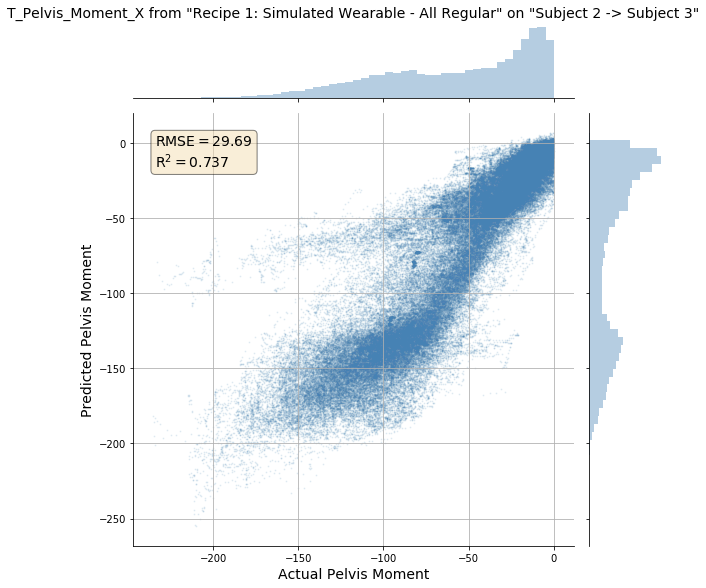

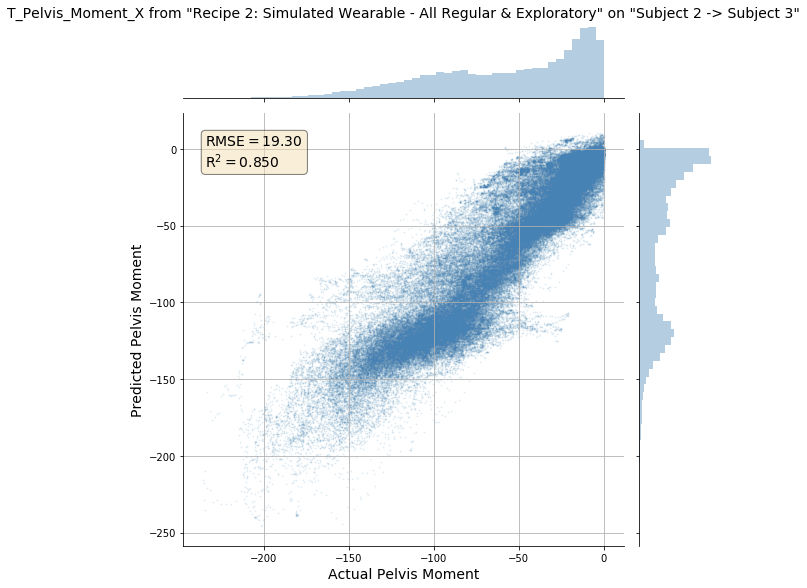

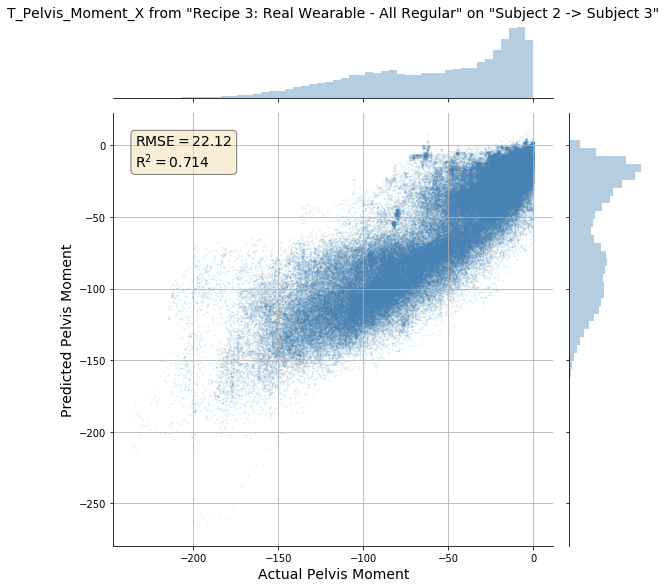

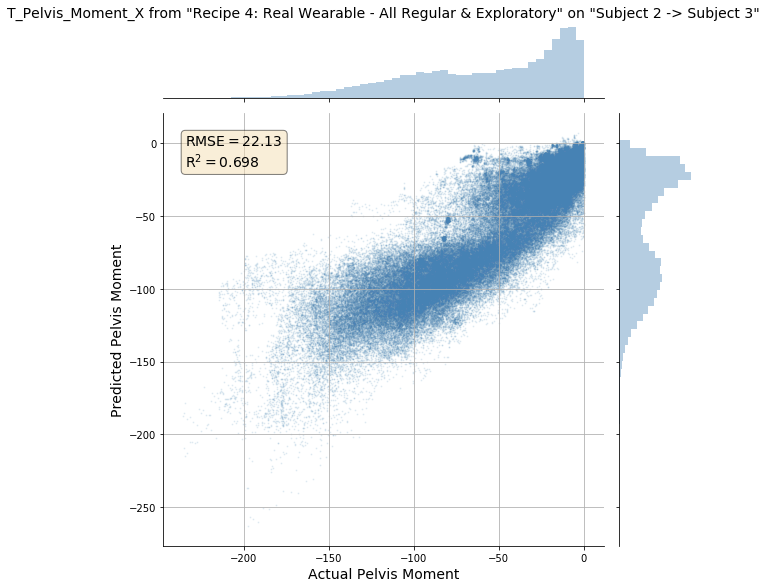

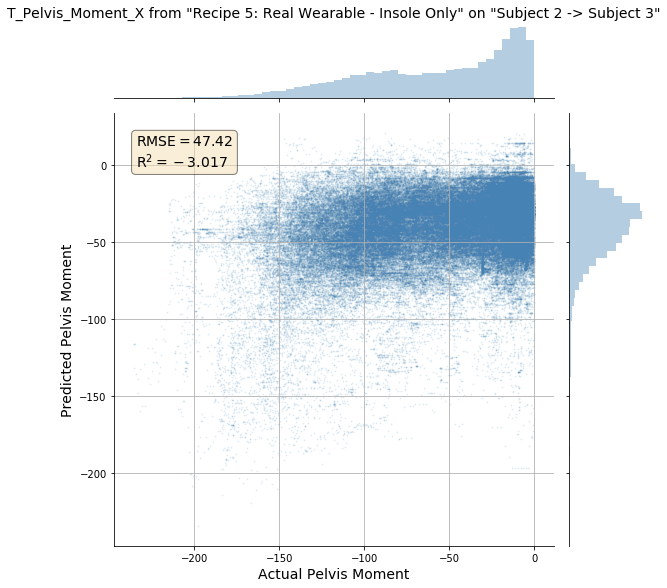

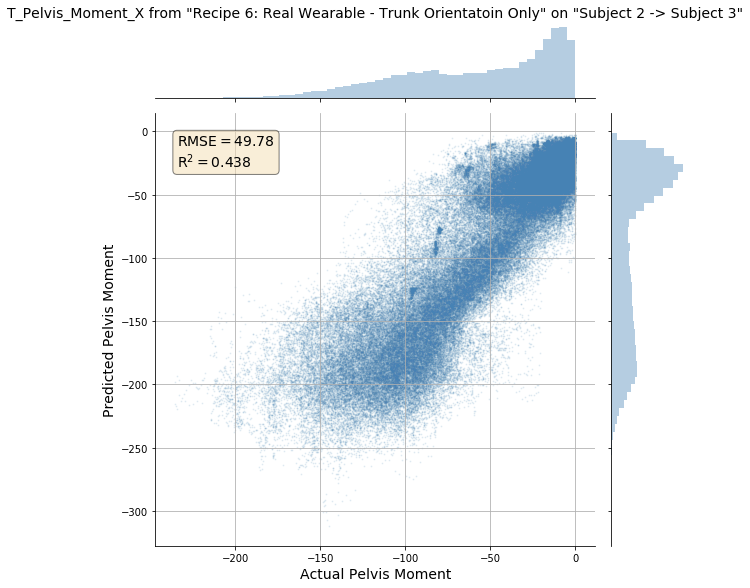

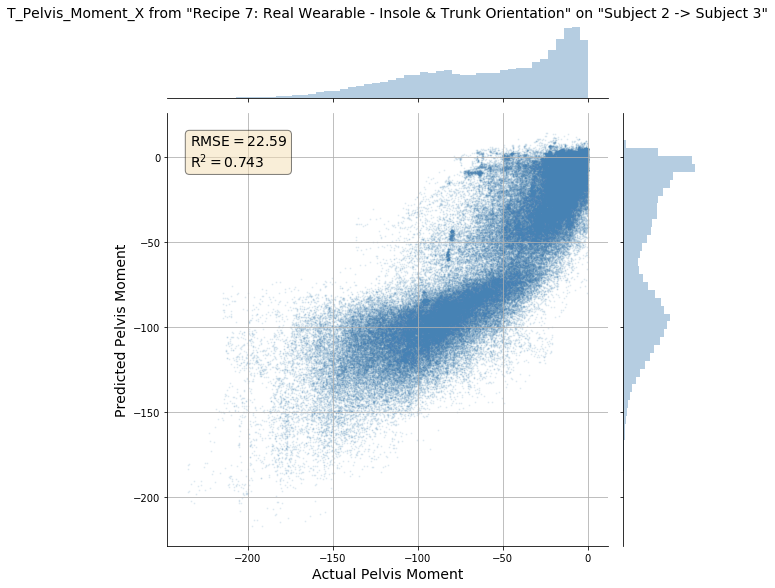

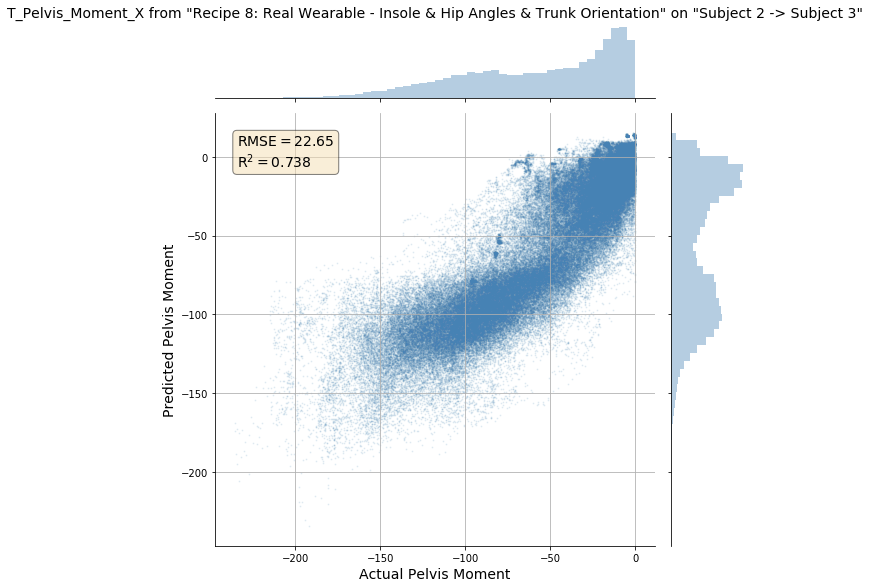

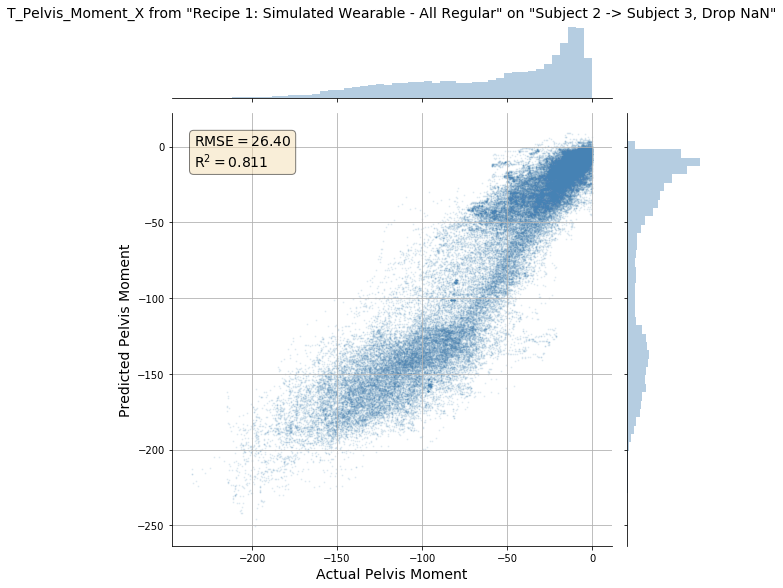

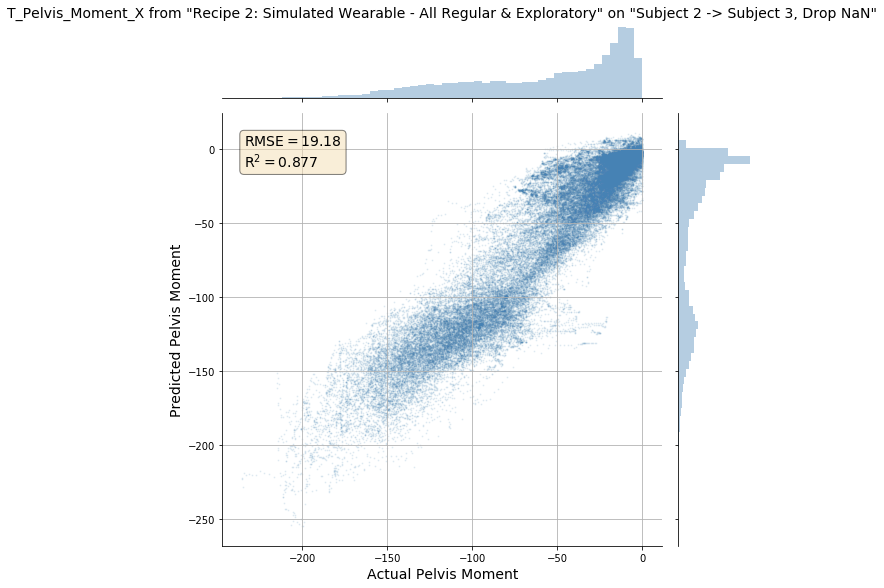

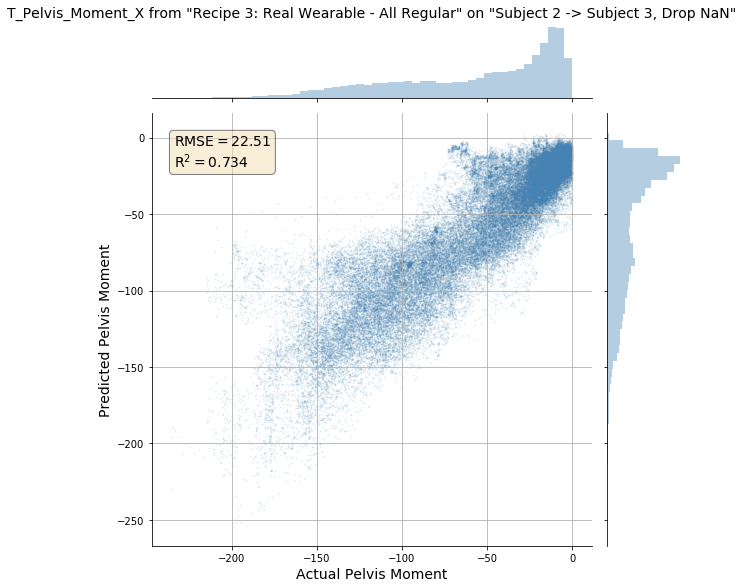

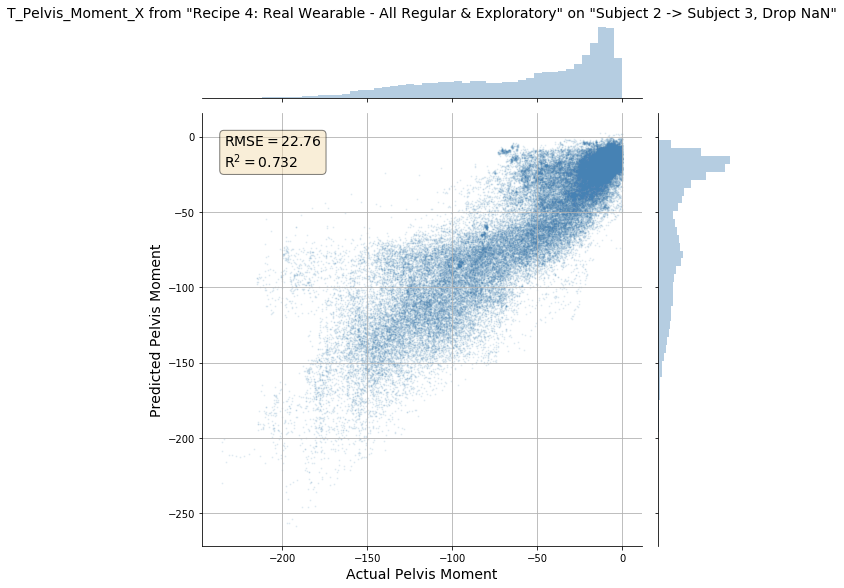

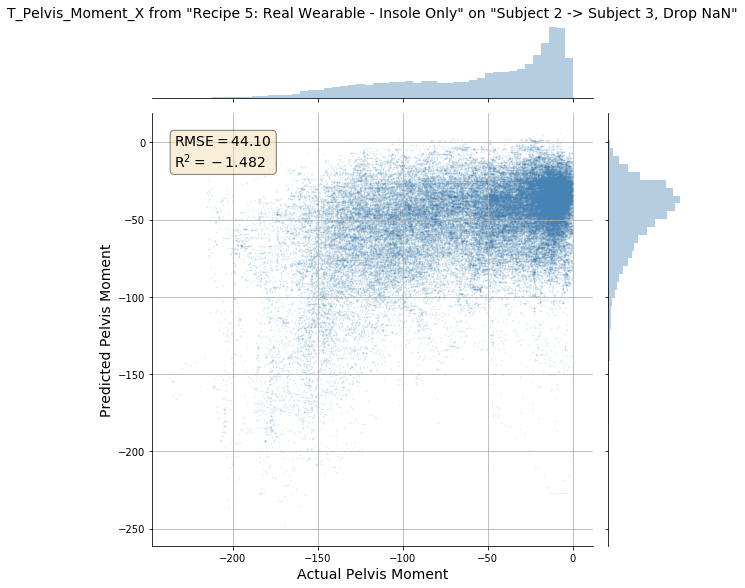

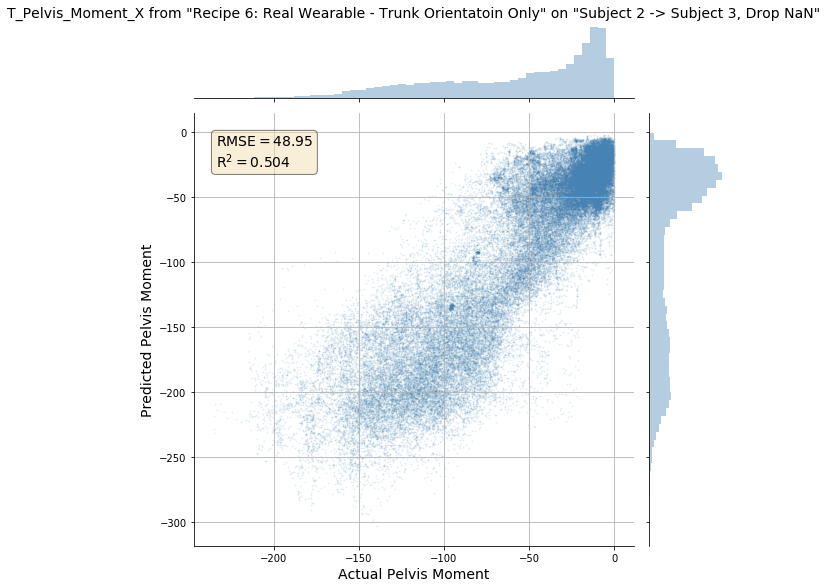

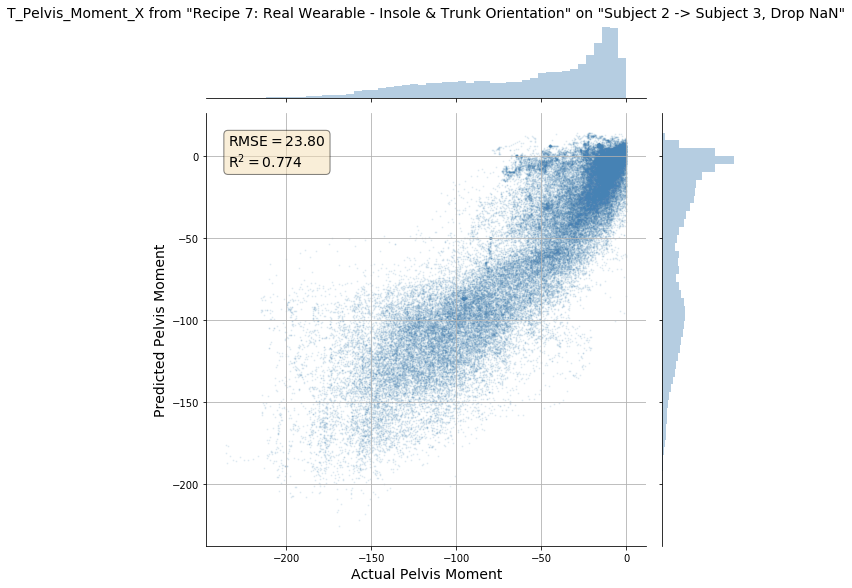

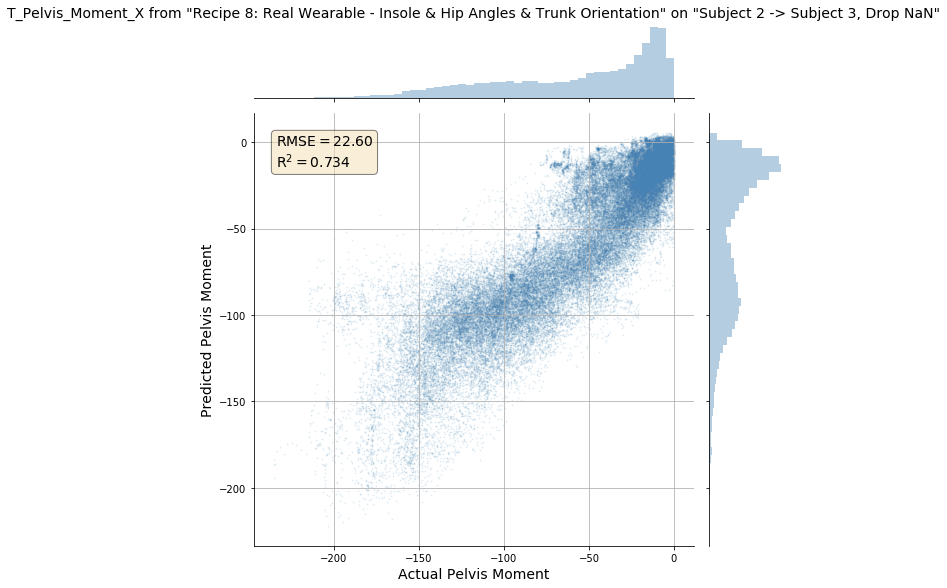

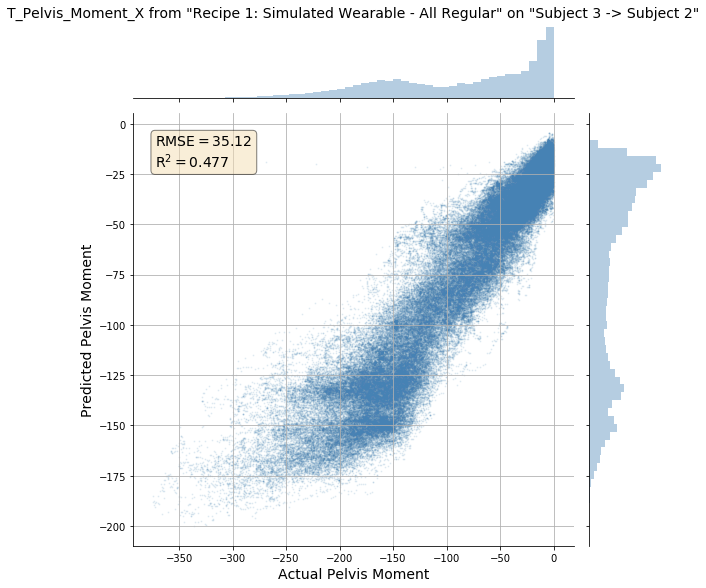

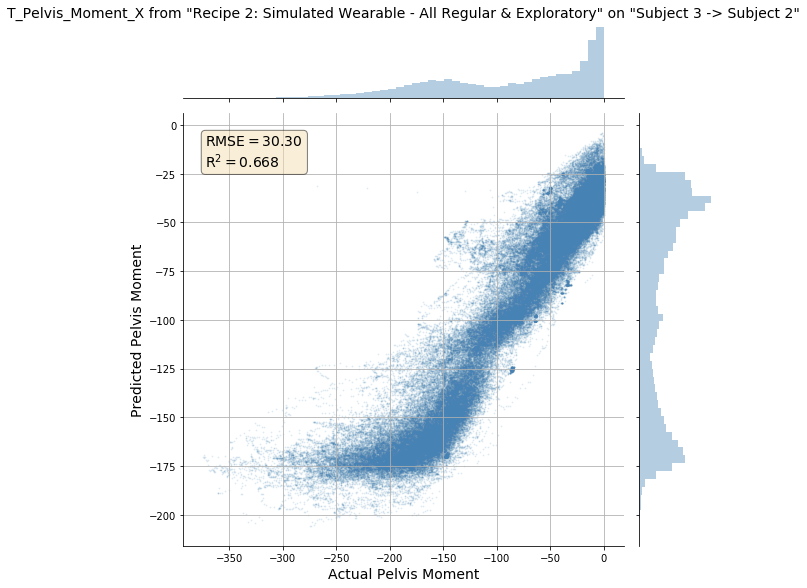

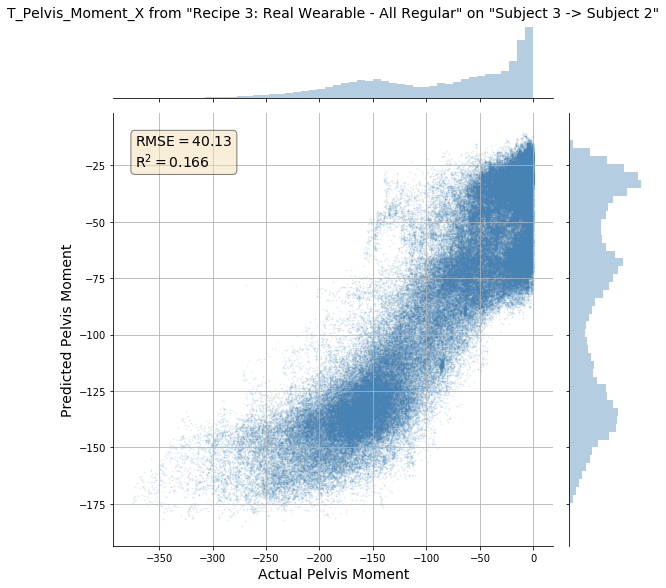

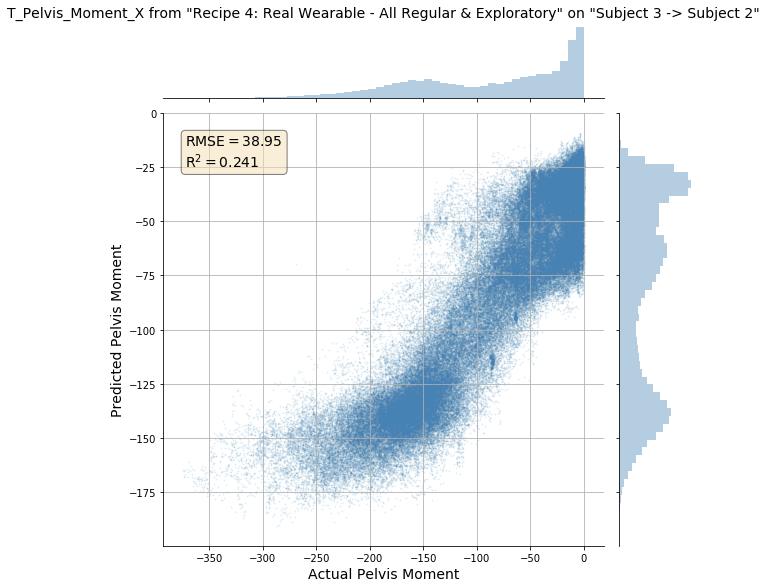

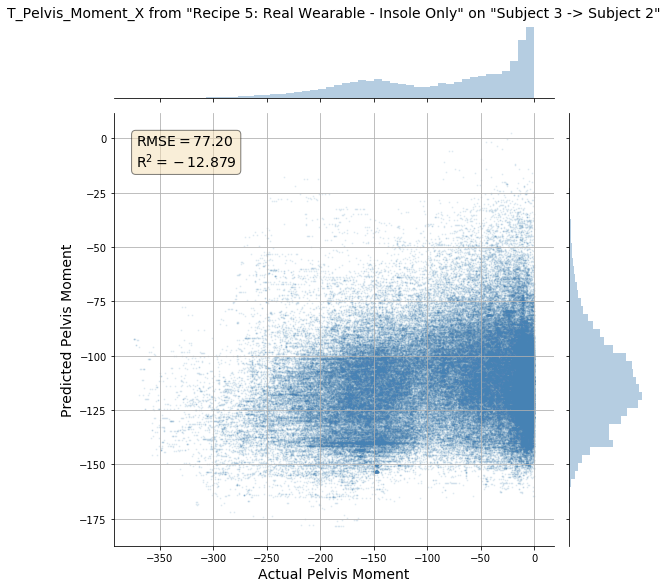

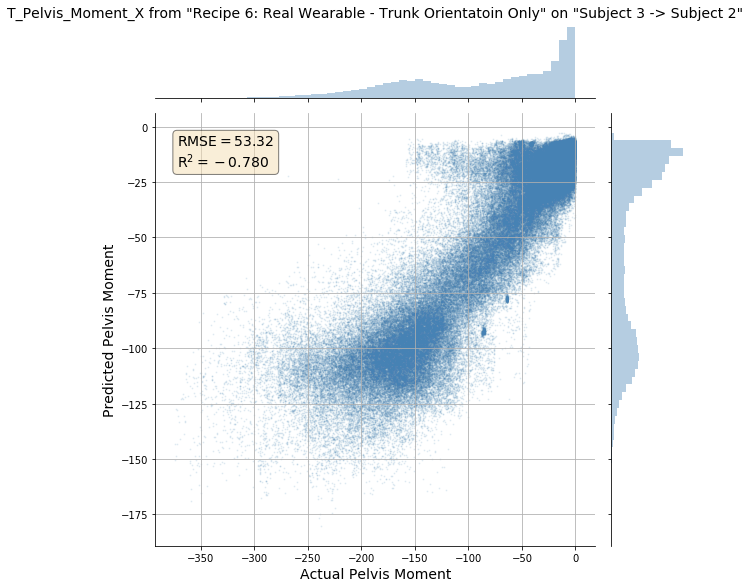

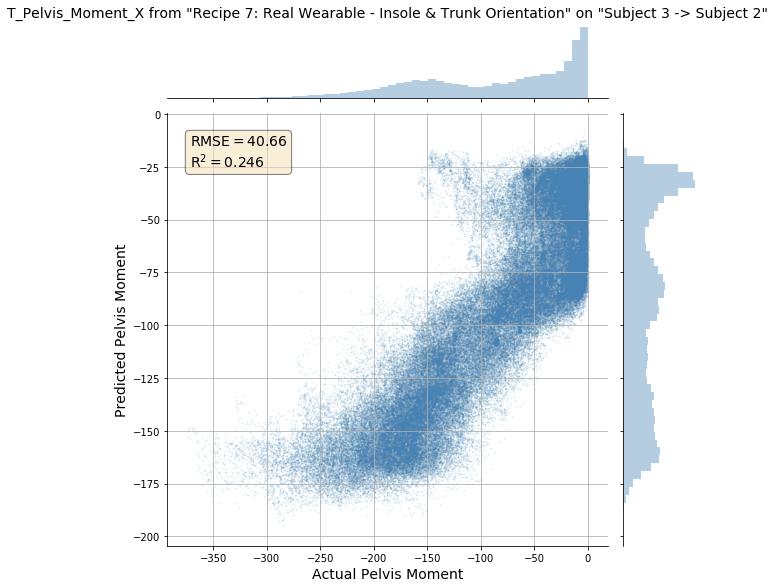

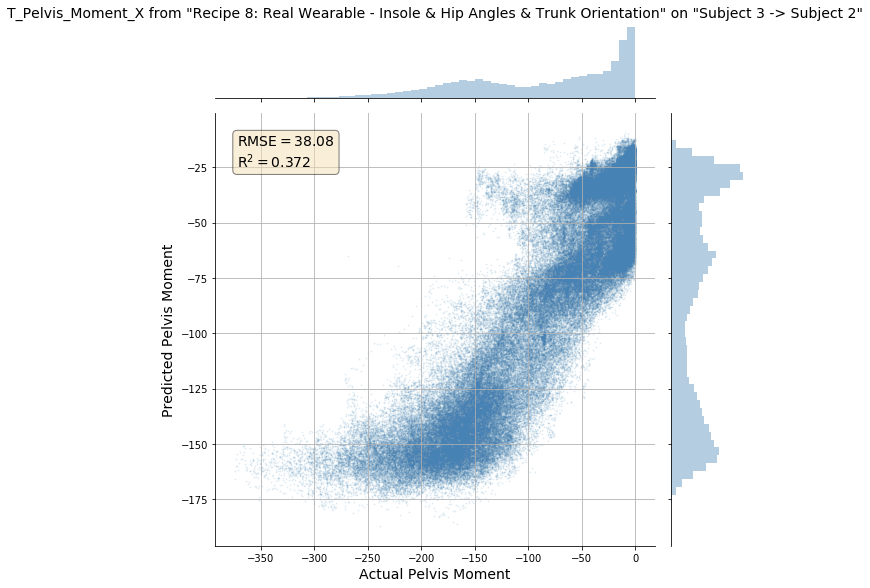

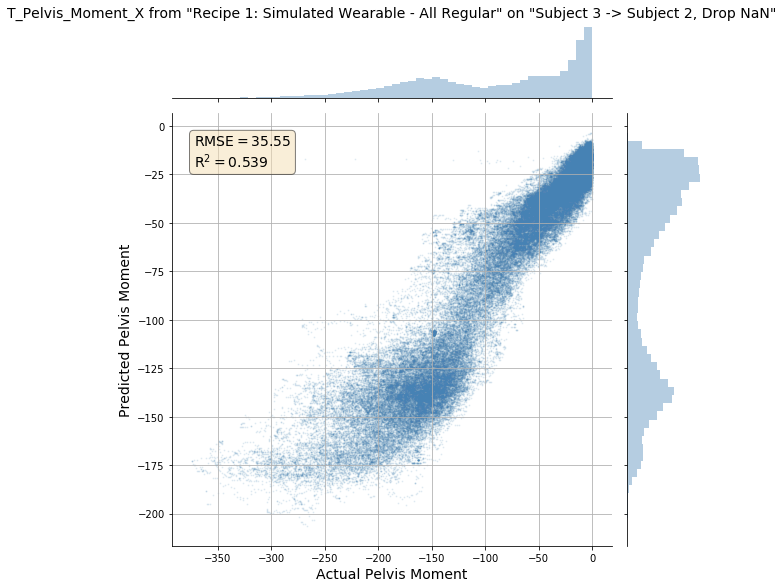

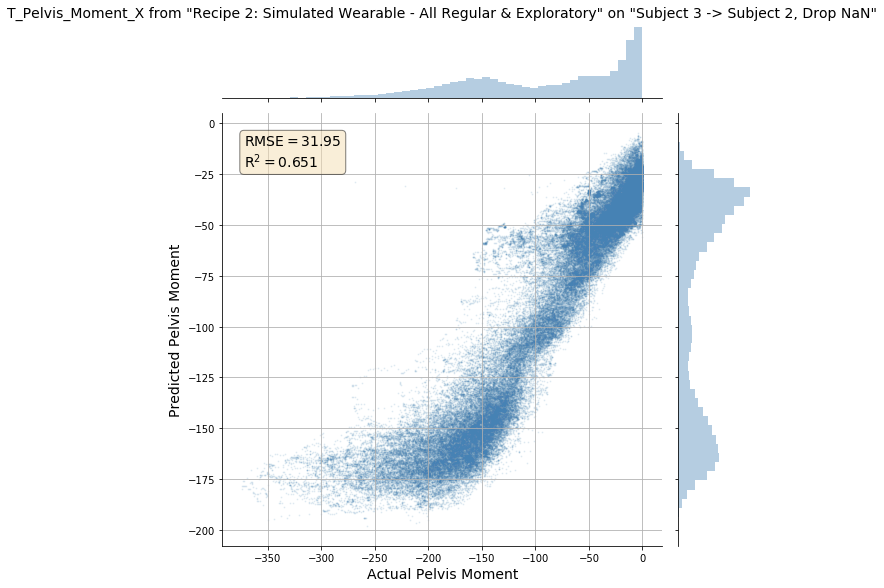

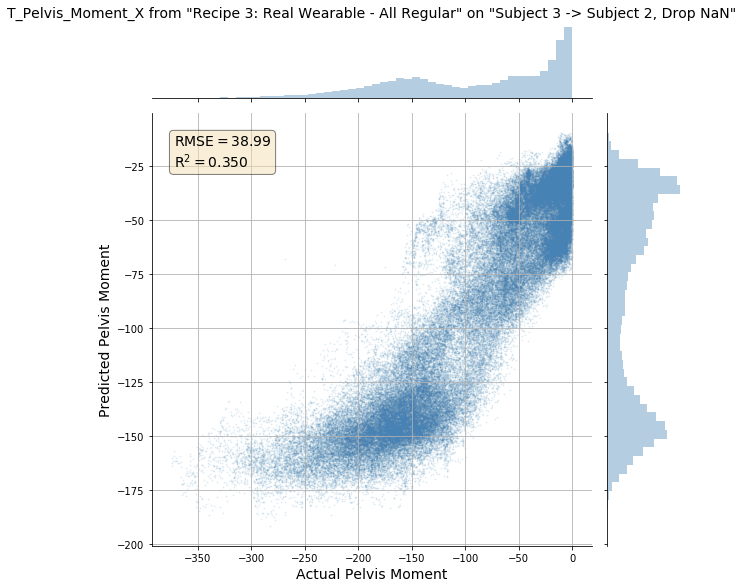

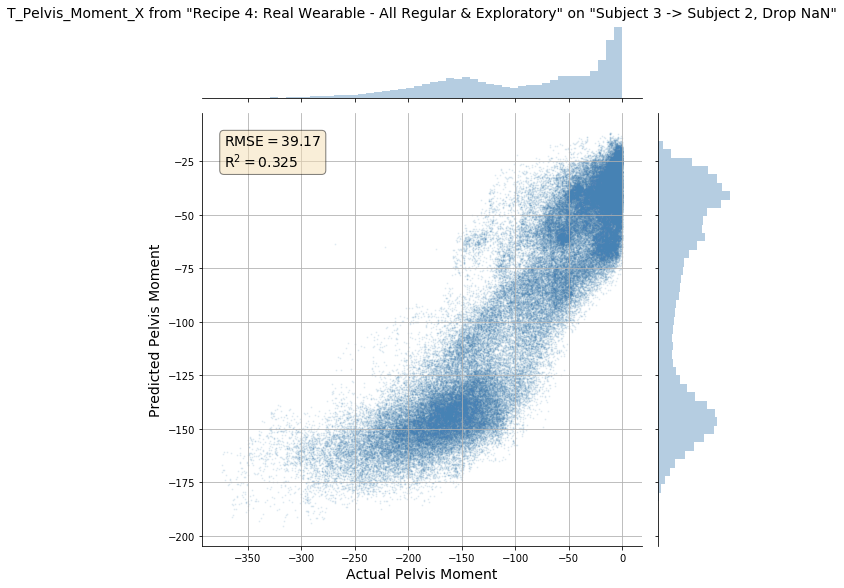

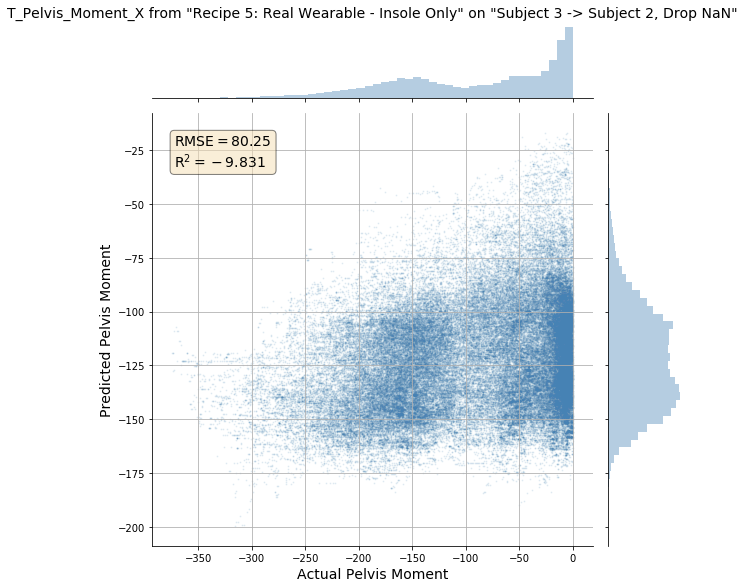

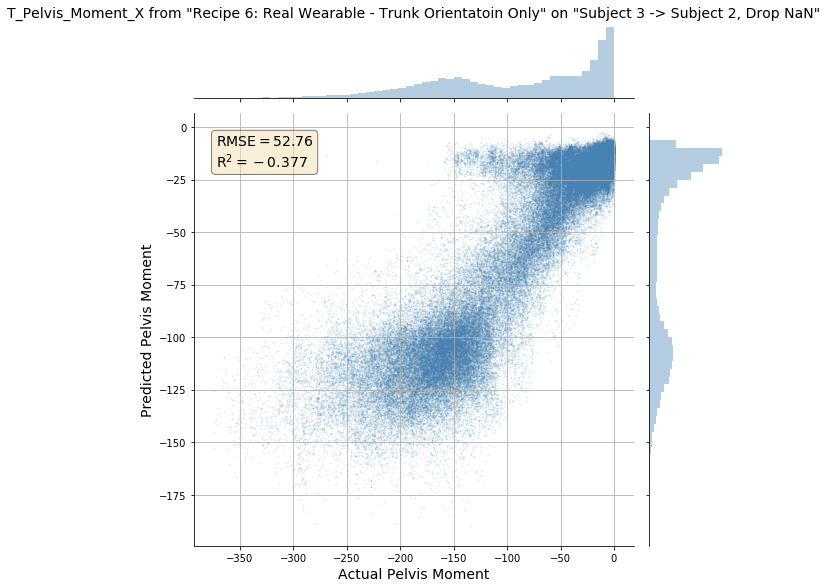

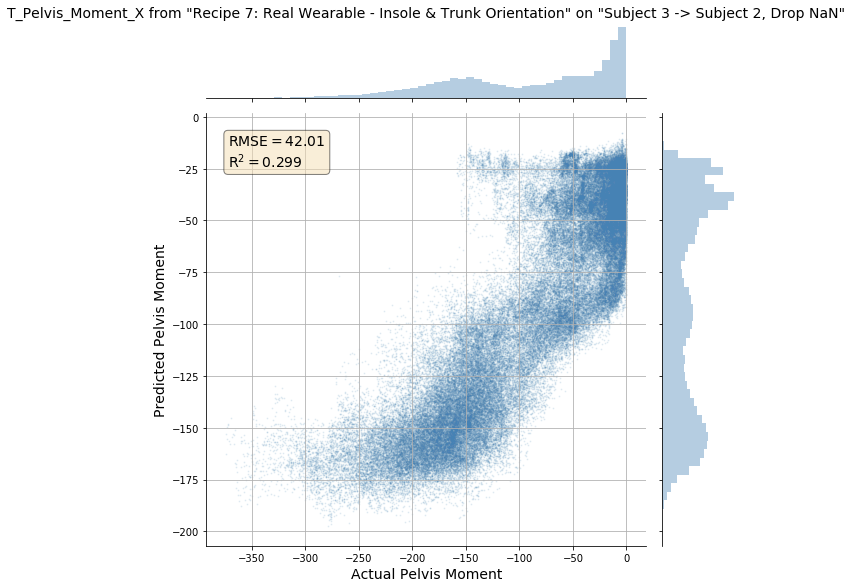

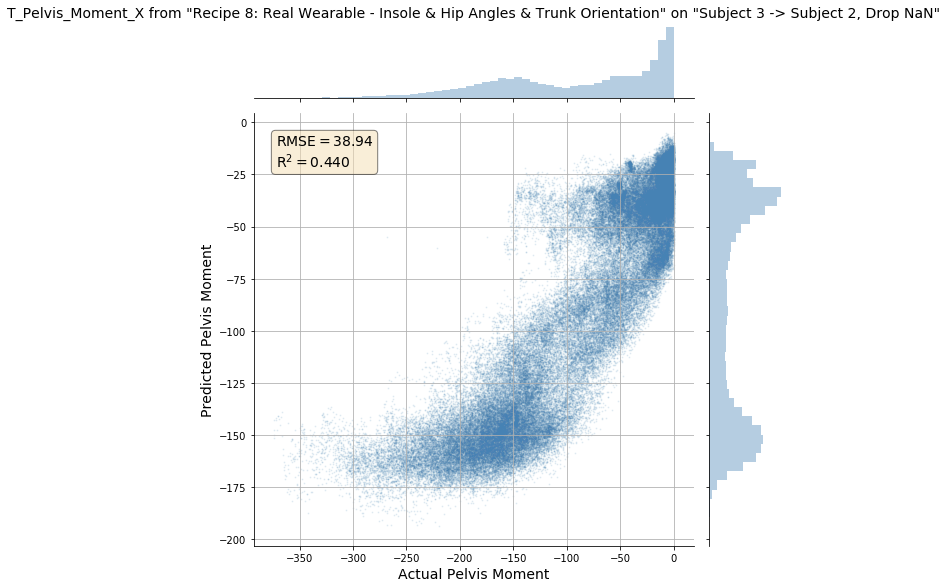

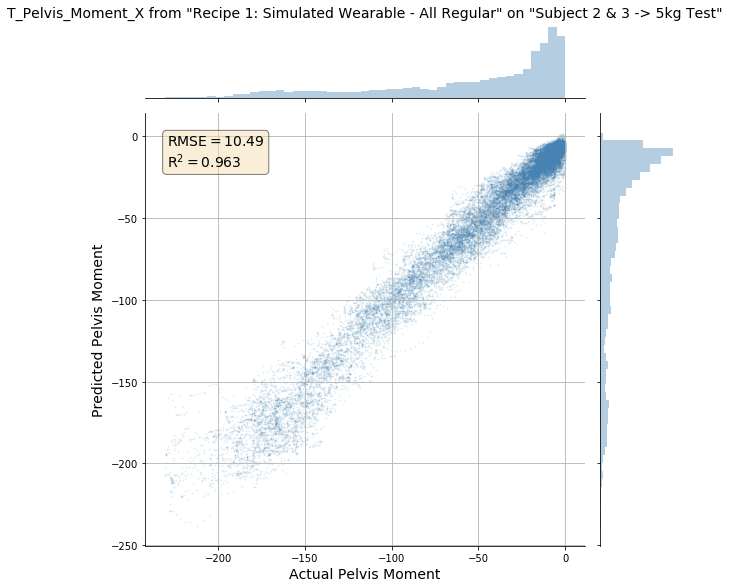

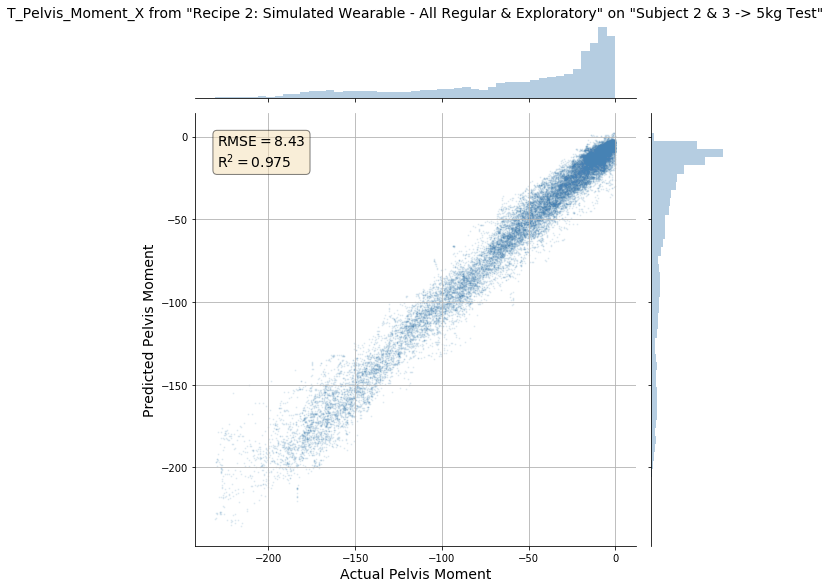

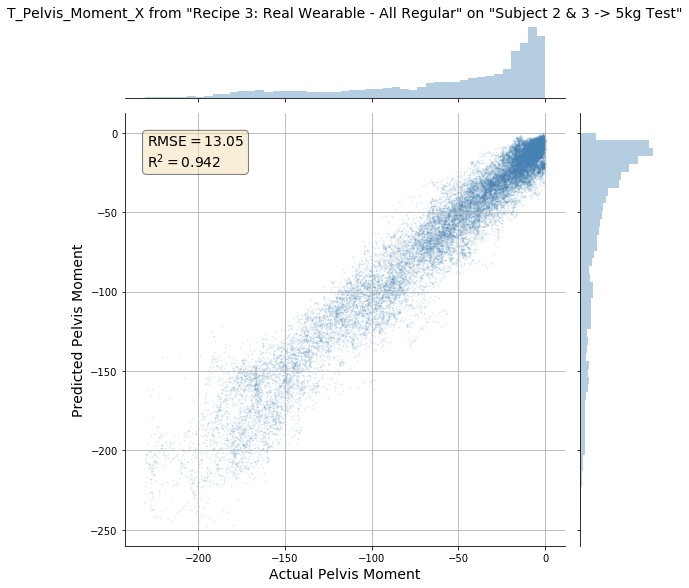

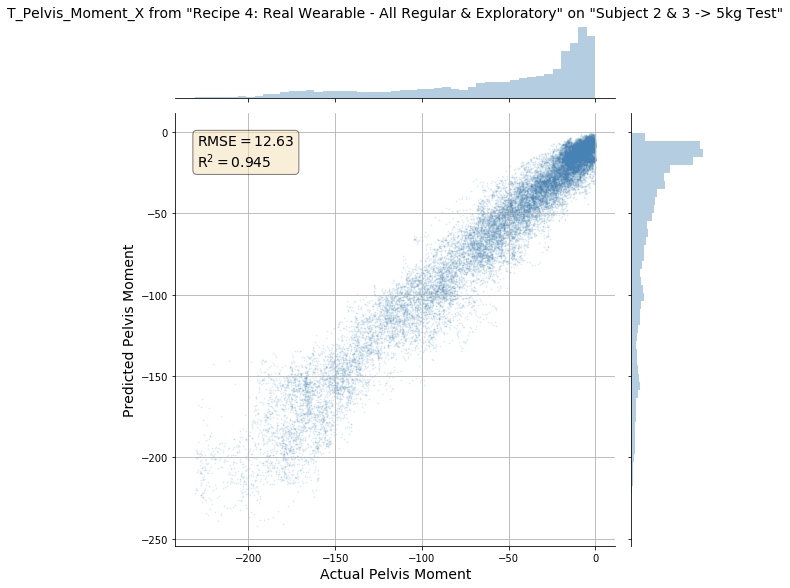

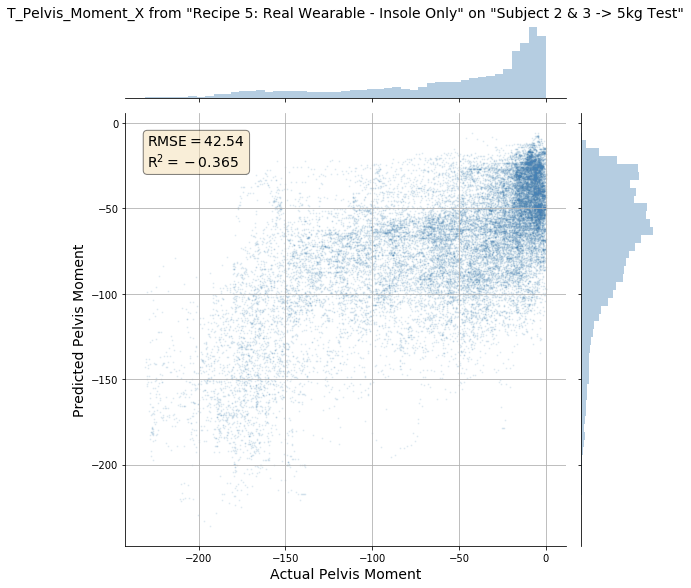

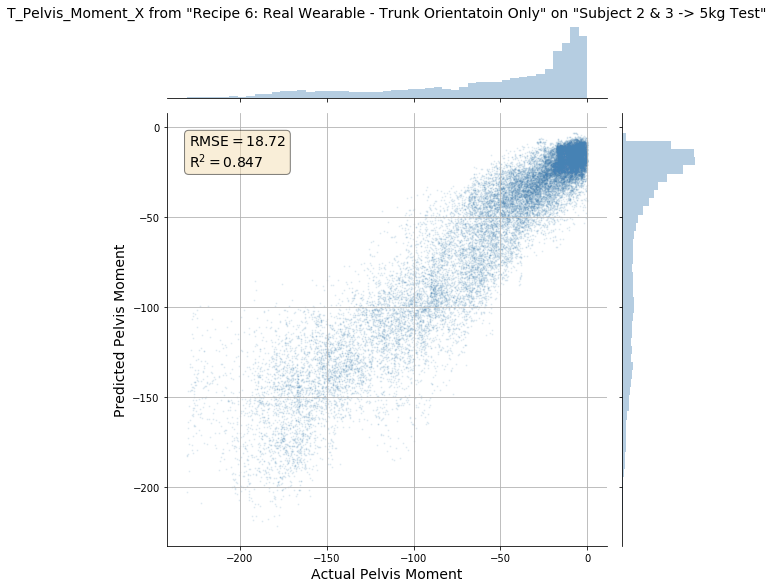

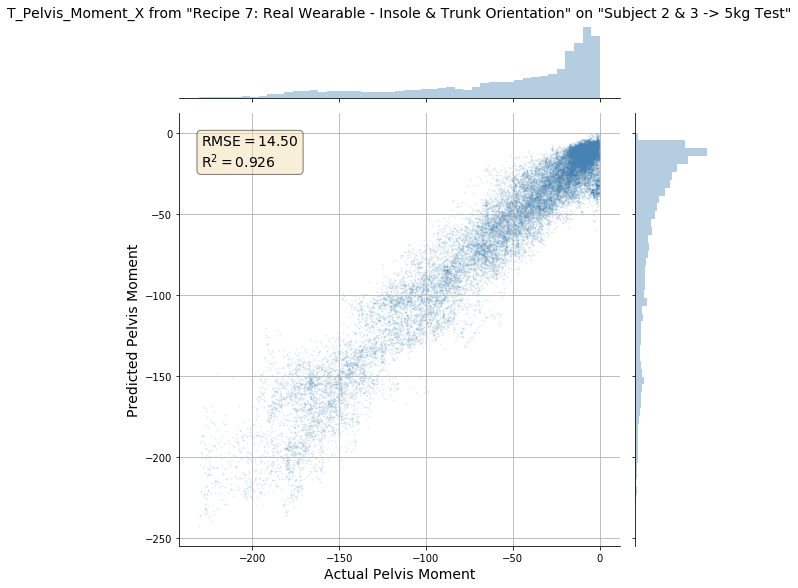

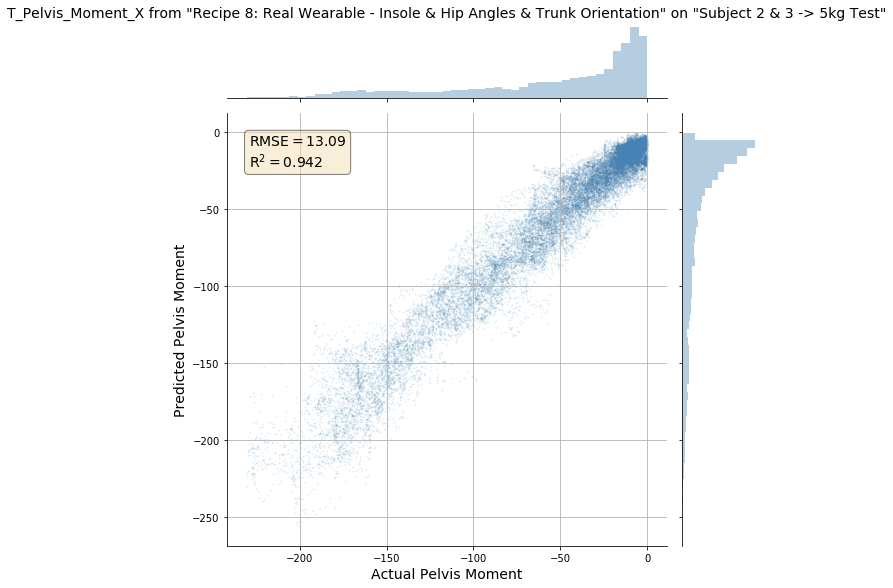

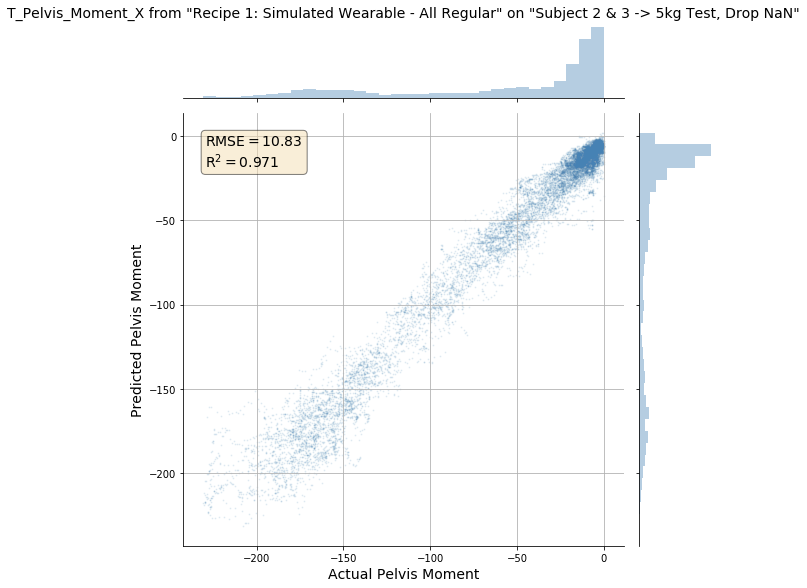

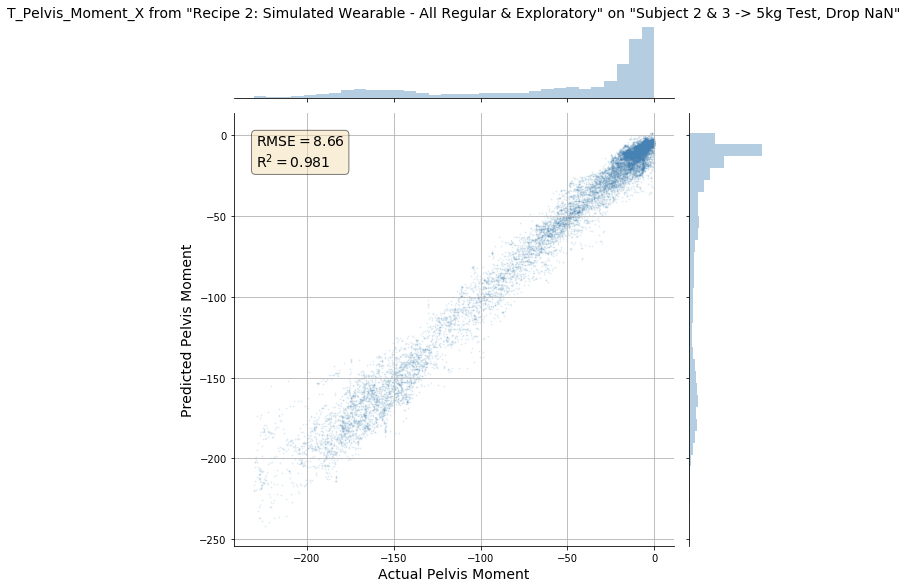

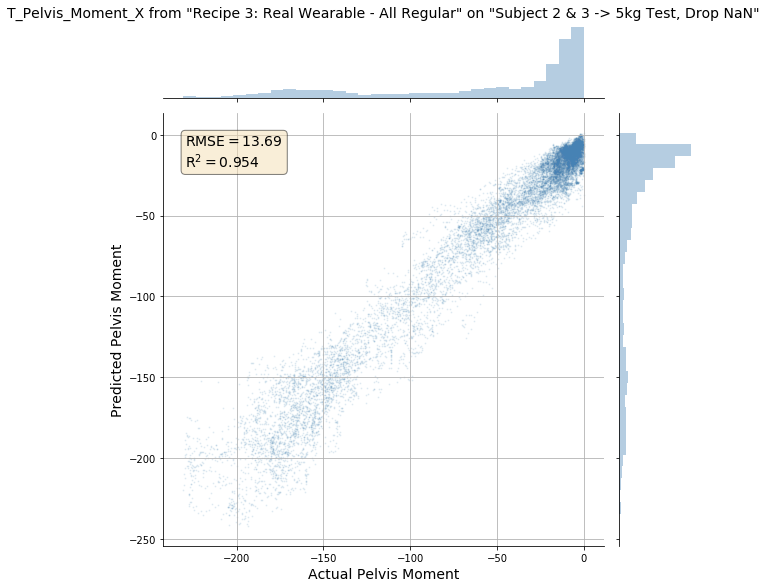

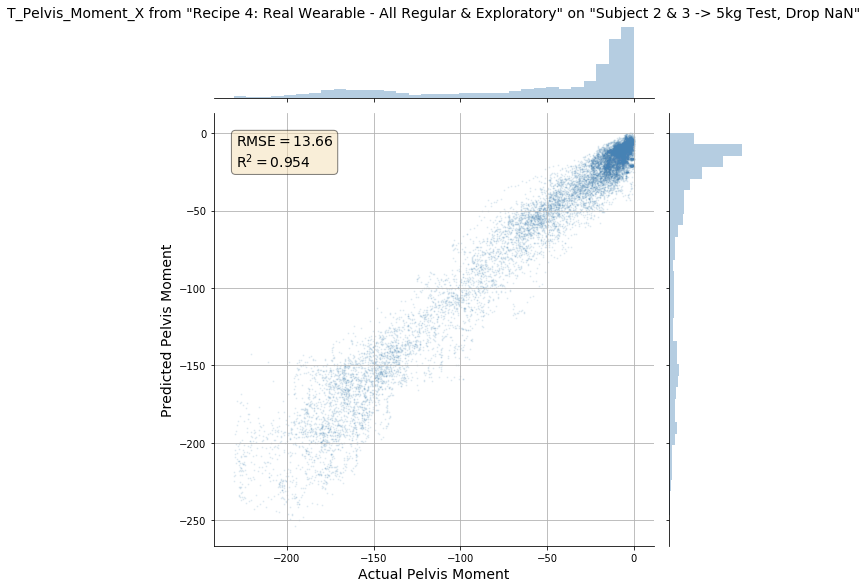

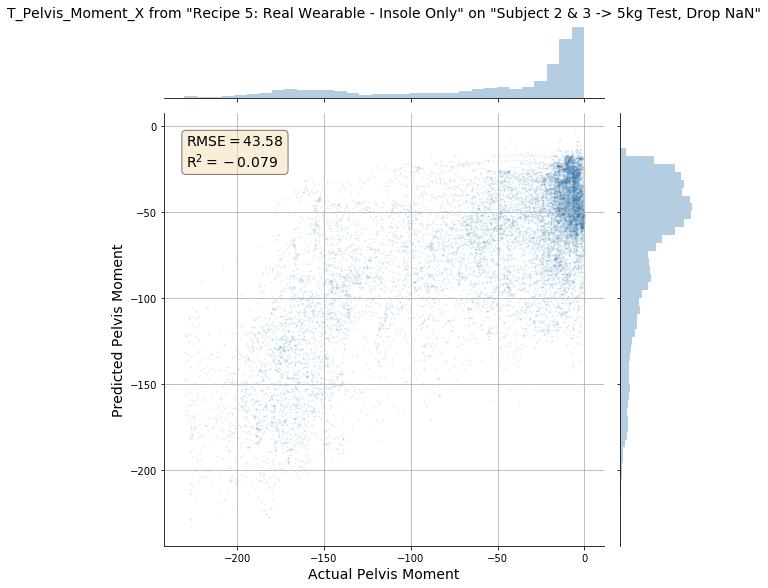

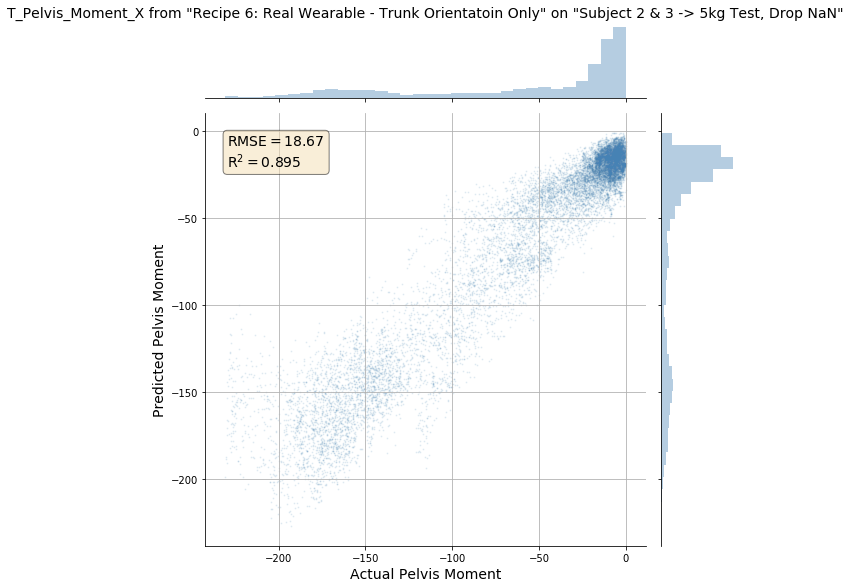

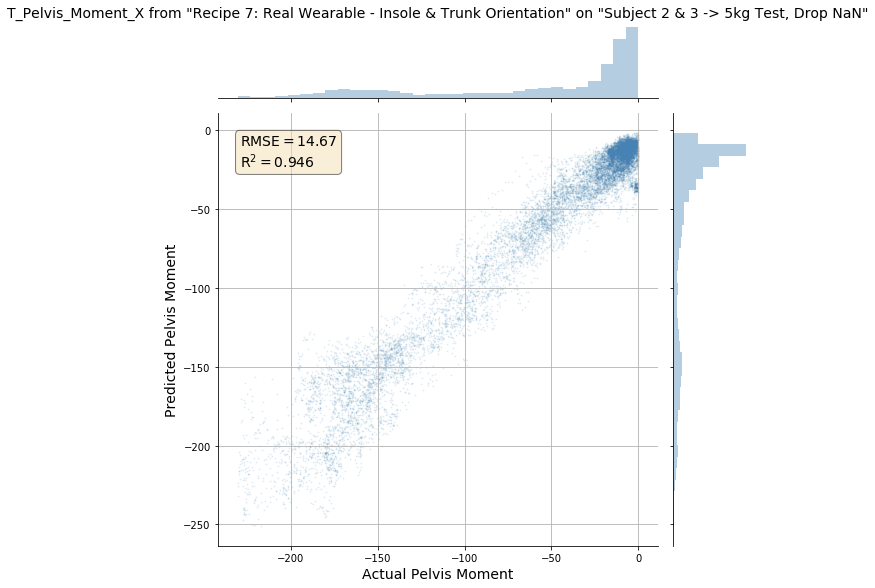

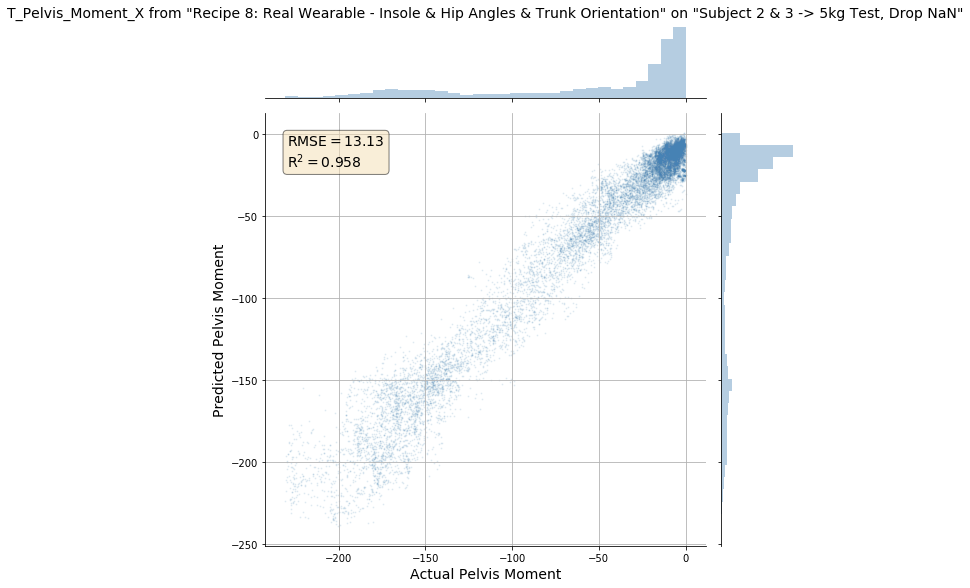

In [14]:
def train_model(X_train, y_train):
    model = pipeline.Pipeline([
        ('scaler', preprocessing.StandardScaler()),
        ('gboost', ensemble.HistGradientBoostingRegressor())
    ]).fit(X_train, y_train)
    return model
    
def evaluate_model(title, model, X_test, y_test, show_plot=False):
    y_test_pred = model.predict(X_test)
    
    # Quantitative results
    rmse = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
    r2 = metrics.r2_score(y_test_pred, y_test)
    
    if show_plot:
        ax = sns.jointplot(y_test, y_test_pred, alpha=0.1, s=1.0, color="steelblue", height=8)
        ax.set_axis_labels("Actual Pelvis Moment", 'Predicted Pelvis Moment', fontsize=14)
        ax.ax_joint.grid()
        ax.ax_marg_x.set_title(title, fontsize=14)

        summary = '\n'.join((
            r"$\mathrm{RMSE}=%.2f$" % (rmse,),
            r"$\mathrm{R}^2=%.3f$" % (r2,)
        ))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.ax_joint.text(0.05, 0.95, summary, transform=ax.ax_joint.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return r2


target_name = "T_Pelvis_Moment_X"
results = {}
for train_test_set_name, (df_train, df_test) in train_test_sets.items():
    for feature_set_name, feature_names in feature_sets.items():
        title = f'{target_name} from "{feature_set_name}" on "{train_test_set_name}"'
        print(title, ":")
        model = train_model(df_train[feature_names], df_train[target_name])
        r2 = evaluate_model(title, model, df_test[feature_names], df_test[target_name], True)
        print(f"\t{r2:.3f}")
        results.setdefault(train_test_set_name, {})[feature_set_name] = r2


## Understanding Normalization

In [8]:
feature_sets = {
    "Recipe 101: Simulated Wearable (Non-normalized target, all features)": [
        'SWR_.*_LUMBAR_ANGLE_X_FE',
        'SWR_.*_LUMBAR_ANGLE_Y_LB',
        'SWR_.*_LUMBAR_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ANKLE_ANGLE_X_FE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_LEFT_ANKLE_ANGLE_X_FE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_KNEE_ANGLE_X_FE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Z_RO',
        'SWR_.*_LEFT_KNEE_ANGLE_X_FE',
        'SWR_.*_LEFT_KNEE_ANGLE_Y_IE',
        'SWR_.*_LEFT_KNEE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_HIP_ANGLE_X_FE',
        'SWR_.*_RIGHT_HIP_ANGLE_Y_IE',
        'SWR_.*_RIGHT_HIP_ANGLE_Z_RO',
        'SWR_.*_LEFT_HIP_ANGLE_X_FE',
        'SWR_.*_LEFT_HIP_ANGLE_Y_IE',
        'SWR_.*_LEFT_HIP_ANGLE_Z_RO',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_LEFT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ELBOW_ANGLE_X_FE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_LEFT_ELBOW_ANGLE_X_FE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_GRF_RightFoot_Z',
        'SWR_.*_GRF_LeftFoot_Z',
        'SWR_.*_CoP_RightFoot_X_ML',
        'SWR_.*_CoP_RightFoot_Y_AP',
        'SWR_.*_CoP_LeftFoot_X_ML',
        'SWR_.*_CoP_LeftFoot_Y_AP',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_TRUNK_ANGLE_VL_X_sag',
        'SWR_.*_TRUNK_ANGLE_VL_Y_fro',
        'SWR_.*_TRUNK_ANGLE_VL_Z_tra',
        'SWR_.*_PELVIS_ANGLE_VL_X_sag',
        'SWR_.*_PELVIS_ANGLE_VL_Y_fro',
        'SWR_.*_PELVIS_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Z_tra',
        'SWE_.*_GRF_total',
        'SWE_.*_R_Ankle_Moment_sag',
        'SWE_.*_L_Ankle_Moment_sag',
        'SWE_.*_R_Ankle_Moment_fro',
        'SWE_.*_L_Ankle_Moment_fro',
        'SWE_.*_cos_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sin_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sinLUMBAR_FEx_FORCETOT',
        'SWE_.*_LUMBAR_FE_x_FORCETOT',
        'SWE_.*_cos_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sin_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sinLUMBAR_LBx_FORCETOT',
        'SWE_.*_LUMBAR_LB_x_FORCETOT',
        'SWE_.*_cos_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_cos_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_cosRHIP_x_FTOT',
        'SWE_.*_sinRHIP_x_FTOT',
        'SWE_.*_RHIP_x_FTOT',
        'SWE_.*_cosLHIP_x_FTOT',
        'SWE_.*_sinLHIP_x_FTOT',
        'SWE_.*_LHIP_x_FTOT',
        'SWE_.*_GRF_RightFoot_Z_BW',
        'SWE_.*_GRF_LeftFoot_Z_BW',
        'SWE_.*_GRF_total_BW',
        'SWE_.*_R_Ankle_Moment_sag_BW',
        'SWE_.*_L_Ankle_Moment_sag_BW',
        'SWE_.*_R_Ankle_Moment_fro_BW',
        'SWE_.*_L_Ankle_Moment_fro_BW',
        'SWE_.*_sinLUMBAR_FEx_FORCETOT_BW',
        'SWE_.*_LUMBAR_FE_x_FORCETOT_BW',
        'SWE_.*_cosRHIP_x_FTOT_BW',
        'SWE_.*_sinRHIP_x_FTOT_BW',
        'SWE_.*_RHIP_x_FTOT_BW',
        'SWE_.*_cosLHIP_x_FTOT_BW',
        'SWE_.*_sinLHIP_x_FTOT_BW',
        'SWE_.*_LHIP_x_FTOT_BW'
        ],
    "Recipe 102: Simulated Wearable (Non-normalized target, non-normalized features)": [
        'SWR_.*_LUMBAR_ANGLE_X_FE',
        'SWR_.*_LUMBAR_ANGLE_Y_LB',
        'SWR_.*_LUMBAR_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ANKLE_ANGLE_X_FE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_LEFT_ANKLE_ANGLE_X_FE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_KNEE_ANGLE_X_FE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Z_RO',
        'SWR_.*_LEFT_KNEE_ANGLE_X_FE',
        'SWR_.*_LEFT_KNEE_ANGLE_Y_IE',
        'SWR_.*_LEFT_KNEE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_HIP_ANGLE_X_FE',
        'SWR_.*_RIGHT_HIP_ANGLE_Y_IE',
        'SWR_.*_RIGHT_HIP_ANGLE_Z_RO',
        'SWR_.*_LEFT_HIP_ANGLE_X_FE',
        'SWR_.*_LEFT_HIP_ANGLE_Y_IE',
        'SWR_.*_LEFT_HIP_ANGLE_Z_RO',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_LEFT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ELBOW_ANGLE_X_FE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_LEFT_ELBOW_ANGLE_X_FE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_GRF_RightFoot_Z',
        'SWR_.*_GRF_LeftFoot_Z',
        'SWR_.*_CoP_RightFoot_X_ML',
        'SWR_.*_CoP_RightFoot_Y_AP',
        'SWR_.*_CoP_LeftFoot_X_ML',
        'SWR_.*_CoP_LeftFoot_Y_AP',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_TRUNK_ANGLE_VL_X_sag',
        'SWR_.*_TRUNK_ANGLE_VL_Y_fro',
        'SWR_.*_TRUNK_ANGLE_VL_Z_tra',
        'SWR_.*_PELVIS_ANGLE_VL_X_sag',
        'SWR_.*_PELVIS_ANGLE_VL_Y_fro',
        'SWR_.*_PELVIS_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Z_tra',
        'SWE_.*_GRF_total',
        'SWE_.*_R_Ankle_Moment_sag',
        'SWE_.*_L_Ankle_Moment_sag',
        'SWE_.*_R_Ankle_Moment_fro',
        'SWE_.*_L_Ankle_Moment_fro',
        'SWE_.*_cos_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sin_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sinLUMBAR_FEx_FORCETOT',
        'SWE_.*_LUMBAR_FE_x_FORCETOT',
        'SWE_.*_cos_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sin_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sinLUMBAR_LBx_FORCETOT',
        'SWE_.*_LUMBAR_LB_x_FORCETOT',
        'SWE_.*_cos_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_cos_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_cosRHIP_x_FTOT',
        'SWE_.*_sinRHIP_x_FTOT',
        'SWE_.*_RHIP_x_FTOT',
        'SWE_.*_cosLHIP_x_FTOT',
        'SWE_.*_sinLHIP_x_FTOT',
        'SWE_.*_LHIP_x_FTOT'
    ],
    "Recipe 103: Simulated Wearable (Normalized target, all features)": [
        'SWR_.*_LUMBAR_ANGLE_X_FE',
        'SWR_.*_LUMBAR_ANGLE_Y_LB',
        'SWR_.*_LUMBAR_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ANKLE_ANGLE_X_FE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_LEFT_ANKLE_ANGLE_X_FE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_KNEE_ANGLE_X_FE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Z_RO',
        'SWR_.*_LEFT_KNEE_ANGLE_X_FE',
        'SWR_.*_LEFT_KNEE_ANGLE_Y_IE',
        'SWR_.*_LEFT_KNEE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_HIP_ANGLE_X_FE',
        'SWR_.*_RIGHT_HIP_ANGLE_Y_IE',
        'SWR_.*_RIGHT_HIP_ANGLE_Z_RO',
        'SWR_.*_LEFT_HIP_ANGLE_X_FE',
        'SWR_.*_LEFT_HIP_ANGLE_Y_IE',
        'SWR_.*_LEFT_HIP_ANGLE_Z_RO',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_LEFT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ELBOW_ANGLE_X_FE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_LEFT_ELBOW_ANGLE_X_FE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_GRF_RightFoot_Z',
        'SWR_.*_GRF_LeftFoot_Z',
        'SWR_.*_CoP_RightFoot_X_ML',
        'SWR_.*_CoP_RightFoot_Y_AP',
        'SWR_.*_CoP_LeftFoot_X_ML',
        'SWR_.*_CoP_LeftFoot_Y_AP',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_TRUNK_ANGLE_VL_X_sag',
        'SWR_.*_TRUNK_ANGLE_VL_Y_fro',
        'SWR_.*_TRUNK_ANGLE_VL_Z_tra',
        'SWR_.*_PELVIS_ANGLE_VL_X_sag',
        'SWR_.*_PELVIS_ANGLE_VL_Y_fro',
        'SWR_.*_PELVIS_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Z_tra',
        'SWE_.*_GRF_total',
        'SWE_.*_R_Ankle_Moment_sag',
        'SWE_.*_L_Ankle_Moment_sag',
        'SWE_.*_R_Ankle_Moment_fro',
        'SWE_.*_L_Ankle_Moment_fro',
        'SWE_.*_cos_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sin_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sinLUMBAR_FEx_FORCETOT',
        'SWE_.*_LUMBAR_FE_x_FORCETOT',
        'SWE_.*_cos_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sin_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sinLUMBAR_LBx_FORCETOT',
        'SWE_.*_LUMBAR_LB_x_FORCETOT',
        'SWE_.*_cos_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_cos_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_cosRHIP_x_FTOT',
        'SWE_.*_sinRHIP_x_FTOT',
        'SWE_.*_RHIP_x_FTOT',
        'SWE_.*_cosLHIP_x_FTOT',
        'SWE_.*_sinLHIP_x_FTOT',
        'SWE_.*_LHIP_x_FTOT',
        'SWE_.*_GRF_RightFoot_Z_BW',
        'SWE_.*_GRF_LeftFoot_Z_BW',
        'SWE_.*_GRF_total_BW',
        'SWE_.*_R_Ankle_Moment_sag_BW',
        'SWE_.*_L_Ankle_Moment_sag_BW',
        'SWE_.*_R_Ankle_Moment_fro_BW',
        'SWE_.*_L_Ankle_Moment_fro_BW',
        'SWE_.*_sinLUMBAR_FEx_FORCETOT_BW',
        'SWE_.*_LUMBAR_FE_x_FORCETOT_BW',
        'SWE_.*_cosRHIP_x_FTOT_BW',
        'SWE_.*_sinRHIP_x_FTOT_BW',
        'SWE_.*_RHIP_x_FTOT_BW',
        'SWE_.*_cosLHIP_x_FTOT_BW',
        'SWE_.*_sinLHIP_x_FTOT_BW',
        'SWE_.*_LHIP_x_FTOT_BW'
    ],
    "Recipe 104: Simulated Wearable (Normalized target, non-normalized features)": [
        'SWR_.*_LUMBAR_ANGLE_X_FE',
        'SWR_.*_LUMBAR_ANGLE_Y_LB',
        'SWR_.*_LUMBAR_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ANKLE_ANGLE_X_FE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_LEFT_ANKLE_ANGLE_X_FE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Y_IE',
        'SWR_.*_LEFT_ANKLE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_KNEE_ANGLE_X_FE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Y_IE',
        'SWR_.*_RIGHT_KNEE_ANGLE_Z_RO',
        'SWR_.*_LEFT_KNEE_ANGLE_X_FE',
        'SWR_.*_LEFT_KNEE_ANGLE_Y_IE',
        'SWR_.*_LEFT_KNEE_ANGLE_Z_RO',
        'SWR_.*_RIGHT_HIP_ANGLE_X_FE',
        'SWR_.*_RIGHT_HIP_ANGLE_Y_IE',
        'SWR_.*_RIGHT_HIP_ANGLE_Z_RO',
        'SWR_.*_LEFT_HIP_ANGLE_X_FE',
        'SWR_.*_LEFT_HIP_ANGLE_Y_IE',
        'SWR_.*_LEFT_HIP_ANGLE_Z_RO',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_RIGHT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_LEFT_SHOULDER_ANGLE_X_FE',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Y_AA',
        'SWR_.*_LEFT_SHOULDER_ANGLE_Z_RO',
        'SWR_.*_RIGHT_ELBOW_ANGLE_X_FE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_RIGHT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_LEFT_ELBOW_ANGLE_X_FE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Y_IE',
        'SWR_.*_LEFT_ELBOW_ANGLE_Z_RO',
        'SWR_.*_CoP_RightFoot_X_ML',
        'SWR_.*_CoP_RightFoot_Y_AP',
        'SWR_.*_CoP_LeftFoot_X_ML',
        'SWR_.*_CoP_LeftFoot_Y_AP',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FOOT_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_SHANK_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_THIGH_ANGLE_VL_Z_tra',
        'SWR_.*_TRUNK_ANGLE_VL_X_sag',
        'SWR_.*_TRUNK_ANGLE_VL_Y_fro',
        'SWR_.*_TRUNK_ANGLE_VL_Z_tra',
        'SWR_.*_PELVIS_ANGLE_VL_X_sag',
        'SWR_.*_PELVIS_ANGLE_VL_Y_fro',
        'SWR_.*_PELVIS_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_UARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_UARM_ANGLE_VL_Z_tra',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_RIGHT_FARM_ANGLE_VL_Z_tra',
        'SWR_.*_LEFT_FARM_ANGLE_VL_X_sag',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Y_fro',
        'SWR_.*_LEFT_FARM_ANGLE_VL_Z_tra',
        'SWE_.*_cos_LUMBAR_ANGLE_X_FE',
        'SWE_.*_sin_LUMBAR_ANGLE_X_FE',
        'SWE_.*_cos_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_sin_LUMBAR_ANGLE_Y_LB',
        'SWE_.*_cos_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_RIGHT_HIP_ANGLE_X_FE',
        'SWE_.*_cos_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_sin_LEFT_HIP_ANGLE_X_FE',
        'SWE_.*_cosRHIP_x_FTOT',
        'SWE_.*_sinRHIP_x_FTOT',
        'SWE_.*_RHIP_x_FTOT',
        'SWE_.*_cosLHIP_x_FTOT',
        'SWE_.*_sinLHIP_x_FTOT',
        'SWE_.*_LHIP_x_FTOT',
        'SWE_.*_GRF_RightFoot_Z_BW',
        'SWE_.*_GRF_LeftFoot_Z_BW',
        'SWE_.*_GRF_total_BW',
        'SWE_.*_R_Ankle_Moment_sag_BW',
        'SWE_.*_L_Ankle_Moment_sag_BW',
        'SWE_.*_R_Ankle_Moment_fro_BW',
        'SWE_.*_L_Ankle_Moment_fro_BW',
        'SWE_.*_sinLUMBAR_FEx_FORCETOT_BW',
        'SWE_.*_LUMBAR_FE_x_FORCETOT_BW',
        'SWE_.*_cosRHIP_x_FTOT_BW',
        'SWE_.*_sinRHIP_x_FTOT_BW',
        'SWE_.*_RHIP_x_FTOT_BW',
        'SWE_.*_cosLHIP_x_FTOT_BW',
        'SWE_.*_sinLHIP_x_FTOT_BW',
        'SWE_.*_LHIP_x_FTOT_BW'
    ]
}


for feature_set_name, predictor_patterns in feature_sets.items():
    predictors = []
    for predictor_pattern in predictor_patterns:
        for column in df.columns:
            if re.match(f"^{predictor_pattern}$", column):
                predictors.append(column)
    feature_sets[feature_set_name] = predictors
    sensors = set(map(predictor_sensor_number, predictors))
    print(f"{feature_set_name}\n\tPredictors: {len(predictors)}, Sensors: {len(sensors)}\n")
    
results2 = {}
for train_test_set_name, (df_train, df_test) in train_test_sets.items():
    for feature_set_name, feature_names in feature_sets.items():
        if "103" in feature_set_name or "104" in feature_set_name:
            target_name = "T_Pelvis_Moment_X_BWm"
        else:
            target_name = "T_Pelvis_Moment_X"
        title = f'{target_name} from "{feature_set_name}" on "{train_test_set_name}"'
        print(title, ":")
        model = train_model(df_train[feature_names], df_train[target_name])
        r2 = evaluate_model(title, model, df_test[feature_names], df_test[target_name])
        print(f"\t{r2:.3f}")
        results2.setdefault(train_test_set_name, {})[feature_set_name] = r2


Recipe 101: Simulated Wearable (Non-normalized target, all features)
	Predictors: 113, Sensors: 10

Recipe 102: Simulated Wearable (Non-normalized target, non-normalized features)
	Predictors: 98, Sensors: 10

Recipe 103: Simulated Wearable (Normalized target, all features)
	Predictors: 113, Sensors: 10

Recipe 104: Simulated Wearable (Normalized target, non-normalized features)
	Predictors: 102, Sensors: 10

T_Pelvis_Moment_X from "Recipe 101: Simulated Wearable (Non-normalized target, all features)" on "Subject 2 -> Subject 3" :
	0.850
T_Pelvis_Moment_X from "Recipe 102: Simulated Wearable (Non-normalized target, non-normalized features)" on "Subject 2 -> Subject 3" :
	0.850
T_Pelvis_Moment_X_BWm from "Recipe 103: Simulated Wearable (Normalized target, all features)" on "Subject 2 -> Subject 3" :
	0.781
T_Pelvis_Moment_X_BWm from "Recipe 104: Simulated Wearable (Normalized target, non-normalized features)" on "Subject 2 -> Subject 3" :
	0.850
T_Pelvis_Moment_X from "Recipe 101: Simul

In [10]:
with pd.ExcelWriter('CPAC10S_S02_S03 - Results.xlsx') as writer:
    pd.DataFrame(results).to_excel(writer, sheet_name='Recipes')
    pd.DataFrame(results2).to_excel(writer, sheet_name='Recipes_Normalization')